In [1]:
%%javascript
utils.load_extension('execute_time/ExecuteTime')

<IPython.core.display.Javascript object>

In [2]:
# Import candidate models
from doubt import Boot, QuantileRegressor, QuantileRegressionForest
from sklearn.linear_model import (LinearRegression, PoissonRegressor, 
                                  GammaRegressor, HuberRegressor)
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVR
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor

# Import datasets
from doubt.datasets import (Airfoil, Blog, Concrete, CPU, 
                            FacebookComments, FishBioconcentration,
                            FishToxicity, ForestFire, NewTaipeiHousing,
                            PowerPlant, Protein, Servo,
                            SpaceShuttle, Yacht)

# Import external libraries
import pandas as pd
import numpy as np
from tqdm.auto import tqdm, trange
from scipy.stats import ks_2samp, entropy, kruskal
import matplotlib.pyplot as plt; plt.style.use('ggplot')
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import warnings
from collections import defaultdict
import seaborn as sns
sns.set_theme(style="whitegrid")
import shap

# Import internal classes
from distributions import DistributionShift
from src.psi import psi

In [3]:
pwd

'/Users/cmougan/Desktop/MonitoringUncertainty'

In [4]:
train = pd.read_csv('data/train.csv',nrows=10_000)
test = pd.read_csv('data/dev_out.csv',nrows=10_000)

In [5]:
cols = [
    "fact_time",
    "fact_latitude",
    "fact_longitude",
    "fact_temperature",
    "fact_cwsm_class",
    "climate",
]


In [6]:
X_tr = train.drop(columns=cols).fillna(-1)
y_tr = train.fact_temperature

X_te = test.drop(columns=cols).fillna(-1)
y_te = test.fact_temperature

In [7]:
standard_scaler = StandardScaler()
        
# Scale the dataset
#X_tr = standard_scaler.fit_transform(X_tr)
#X_te = standard_scaler.transform(X_te)


# Fit the regressor
regressor = Boot(XGBRegressor(max_depth=5,n_estimators=50))
regressor.fit(X_tr, y_tr,n_boots=20)


Boot(model=XGBRegressor, random_seed=None)

In [8]:
# Train preds
predictions, intervals = regressor.predict(X_tr, uncertainty=0.05)


In [9]:
values = {}
values["uncertainty_train"] = intervals[:, 1] - intervals[:, 0]
values["mse_train"] = (predictions - y_tr) ** 2


In [10]:
# Test preds
predictions, intervals = regressor.predict(X_te, uncertainty=0.05)
values["uncertainty_test"] = intervals[:, 1] - intervals[:, 0]
values["mse_test"] = (predictions - y_te) ** 2


d = pd.DataFrame(values)

In [11]:
sc = StandardScaler()
sc.fit(d['uncertainty_train'].values.reshape(-1, 1))
d['uncertainty_train'] = sc.transform(d['uncertainty_train'].values.reshape(-1, 1))
d['uncertainty_test'] = sc.transform(d['uncertainty_test'].values.reshape(-1, 1))

sc = StandardScaler()
sc.fit(d['mse_train'].values.reshape(-1, 1))
d['mse_train'] = sc.transform(d['mse_train'].values.reshape(-1, 1))
d['mse_test'] = sc.transform(d['mse_test'].values.reshape(-1, 1))



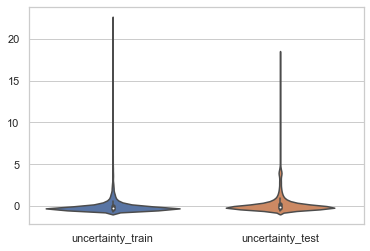

In [12]:
sns.violinplot(data = d.drop(columns=['mse_train','mse_test']));

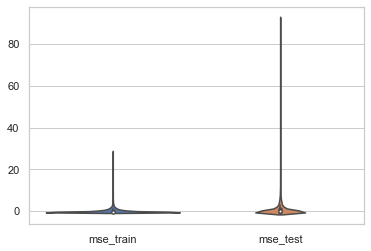

In [13]:
sns.violinplot(data = d.drop(columns=['uncertainty_train','uncertainty_test']));

In [14]:
d.describe()

,uncertainty_train,mse_train,uncertainty_test,mse_test
count,1.000000e+04,1.000000e+04,10000.000000,10000.000000
mean,-9.222845e-16,2.113865e-17,0.283262,0.885752
std,1.000050e+00,1.000050e+00,1.337496,3.147273
min,-6.977390e-01,-5.642019e-01,-0.583291,-0.564202
25%,-4.038300e-01,-5.197172e-01,-0.278367,-0.468981
50%,-2.602882e-01,-3.539719e-01,-0.110486,-0.108551
75%,1.210917e-02,1.144703e-01,0.227234,0.907741
max,2.232802e+01,2.854812e+01,18.110843,91.999769


## Detecting the source of uncertainty

In [15]:
reg = XGBRegressor()
reg.fit(X_te,d['uncertainty_test'])

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [16]:
mean_squared_error(reg.predict(X_te),d['uncertainty_test'])

0.010367168018002651

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


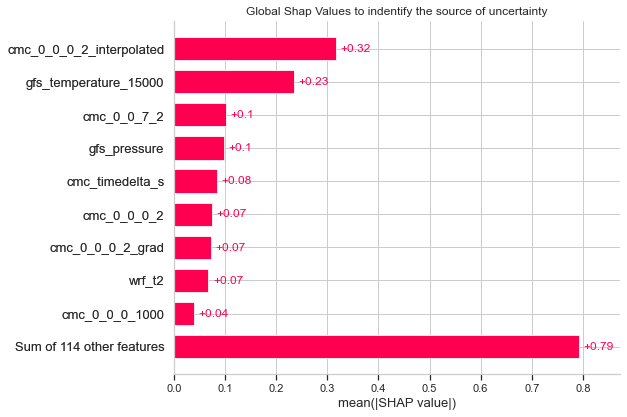

<Figure size 432x288 with 0 Axes>

In [25]:
explainer = shap.Explainer(reg)
shap_values = explainer(X_te)

# visualize the first prediction's explanation
# shap.plots.waterfall(shap_values[0])
plt.figure()
plt.title('Global Shap Values to indentify the source of uncertainty')
shap.plots.bar(shap_values)
plt.savefig('experiments/xai/shap.png')
plt.show()

divide by zero encountered in double_scalars


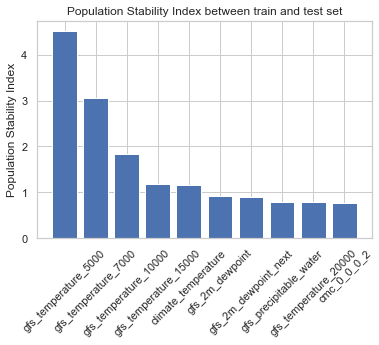

In [24]:
psi_dic = []
for c in X_tr.columns:
    psi_dic.append([c, psi(X_tr[c], X_te[c]),ks_2samp(X_tr[c], X_te[c]).statistic])



psi_dic = pd.DataFrame(psi_dic, columns=["column", "psi",'ks'])


plt.figure()
plt.title('Population Stability Index between train and test set')
plt.ylabel('Population Stability Index')
keys = psi_dic.sort_values("psi", ascending=False).head(10).column.values
values = psi_dic.sort_values("psi", ascending=False).head(10).psi.values

plt.bar(keys, values)
plt.xticks(rotation=45)
plt.savefig('experiments/xai/psi.png')
plt.show()



In [22]:
pwd


'/Users/cmougan/Desktop/MonitoringUncertainty'

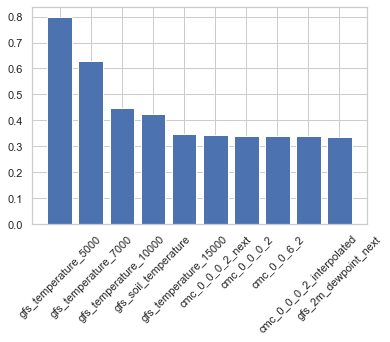

In [21]:
plt.figure()
keys = psi_dic.sort_values("ks", ascending=False).head(10).column.values
values = psi_dic.sort_values("ks", ascending=False).head(10).ks.values

plt.bar(keys, values)
plt.xticks(rotation=45)
plt.show()